In [1]:
# import libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# load the dataset for analysis
df = pd.read_csv('./baby_activity_logs.csv')
df.head()

,baby_activity,time,clock_system,parent_activity,status,unit,month,day,year
0,Diaper,1:00,AM,change,Wet,NaN,February,12,2022
1,Feeding,1:00,AM,Formula,1.69,oz.,February,12,2022
2,Feeding,1:00,PM,Formula,0.5,oz.,March,20,2022
3,Diaper,1:00,PM,change,Wet,NaN,March,20,2022
4,Feeding,1:00,PM,Formula,2,oz.,March,23,2022


In [3]:
# create a new column that combines time columns
df['datetime_str'] =  df['month'] + " " + df['day'].astype(str) + " " + df['year'].astype(str) + " " + df['time'] + " " + df['clock_system']

# Convert to datetime object
df['datetime'] = pd.to_datetime(df['datetime_str'], format='%B %d %Y %I:%M %p')

# Sort by time
df = df.sort_values(by='datetime')

df.head()

,baby_activity,time,clock_system,parent_activity,status,unit,month,day,year,datetime_str,datetime
5539,Diaper,12:37,PM,change,Wet,NaN,February,9,2022,February 9 2022 12:37 PM,2022-02-09 12:37:00
5614,Feeding,12:46,PM,Formula,0.3,oz.,February,9,2022,February 9 2022 12:46 PM,2022-02-09 12:46:00
63,Sleep,1:09,PM,Slept,21,hrs,February,9,2022,February 9 2022 1:09 PM,2022-02-09 13:09:00
1012,Feeding,3:30,PM,Formula,0.5,oz.,February,9,2022,February 9 2022 3:30 PM,2022-02-09 15:30:00
2185,Diaper,6:23,PM,change,Dry,NaN,February,9,2022,February 9 2022 6:23 PM,2022-02-09 18:23:00


In [ ]:
# convert datetime to values important
def convert_time (data_with_time):
    column_names = data_with_time.select_dtypes(include='datetime64').columns
    column = data_with_time[column_names[0]]
    # data_with_time['hour'] = data_with_time['datetime'].dt.hour
    # data_with_time['dayofweek'] = data_with_time['datetime'].dt.dayofweek
    # data_with_time['minutes_since_midnight'] = data_with_time['hour']*60 + data_with_time['datetime'].dt.minute

    data_with_time['hour'] = column.dt.hour
    data_with_time['dayofweek'] = column.dt.dayofweek
    data_with_time['minutes_since_midnight'] = column.dt.hour*60 + column.dt.minute  
    data_with_time['time_diff_min'] = column.diff().dt.total_seconds()/60
    # new_feed_m['time_diff_min'] = new_feed_m['datetime'].diff().dt.total_seconds() / 60  
    
    return data_with_time

In [4]:
df.head(1)

,baby_activity,time,clock_system,parent_activity,status,unit,month,day,year,datetime_str,datetime
5539,Diaper,12:37,PM,change,Wet,NaN,February,9,2022,February 9 2022 12:37 PM,2022-02-09 12:37:00


In [5]:
# filter feeding dataset
feeding_df = df[(df['baby_activity'] == 'Feeding')&(df['parent_activity'] == 'Formula')]
feeding_df = feeding_df[feeding_df['year'] == 2022]

feeding_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2643 entries, 5614 to 3663
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   baby_activity    2643 non-null   object        
 1   time             2643 non-null   object        
 2   clock_system     2643 non-null   object        
 3   parent_activity  2643 non-null   object        
 4   status           2643 non-null   object        
 5   unit             2643 non-null   object        
 6   month            2643 non-null   object        
 7   day              2643 non-null   int64         
 8   year             2643 non-null   int64         
 9   datetime_str     2643 non-null   object        
 10  datetime         2643 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 247.8+ KB


In [6]:
feeding_df['year'].unique()

array([2022])

In [7]:
# set datetime as index
feed_df_new = feeding_df.copy()

feed_df_new = feed_df_new.set_index('datetime')

In [8]:
feed_df_new.head(1)

,baby_activity,time,clock_system,parent_activity,status,unit,month,day,year,datetime_str
datetime,,,,,,,,,,
2022-02-09 12:46:00,Feeding,12:46,PM,Formula,0.3,oz.,February,9,2022,February 9 2022 12:46 PM


In [9]:
feed_df_am = feed_df_new[feed_df_new['clock_system'] == 'AM']
feed_df_pm = feed_df_new[feed_df_new['clock_system'] == 'PM']

In [13]:
selected_columns = feed_df_new[['status']]

selected_columns['status'] = selected_columns.astype('float64')
selected_columns.tail()



C:\Users\Owner\AppData\Local\Temp\ipykernel_1584\3707563818.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns['status'] = selected_columns.astype('float64')


,status
datetime,
2022-12-30 22:25:00,3.5
2022-12-31 06:38:00,3.0
2022-12-31 13:08:00,5.0
2022-12-31 18:37:00,4.0
2022-12-31 21:13:00,3.5


<Axes: title={'center': 'feeding_amount'}, xlabel='datetime'>

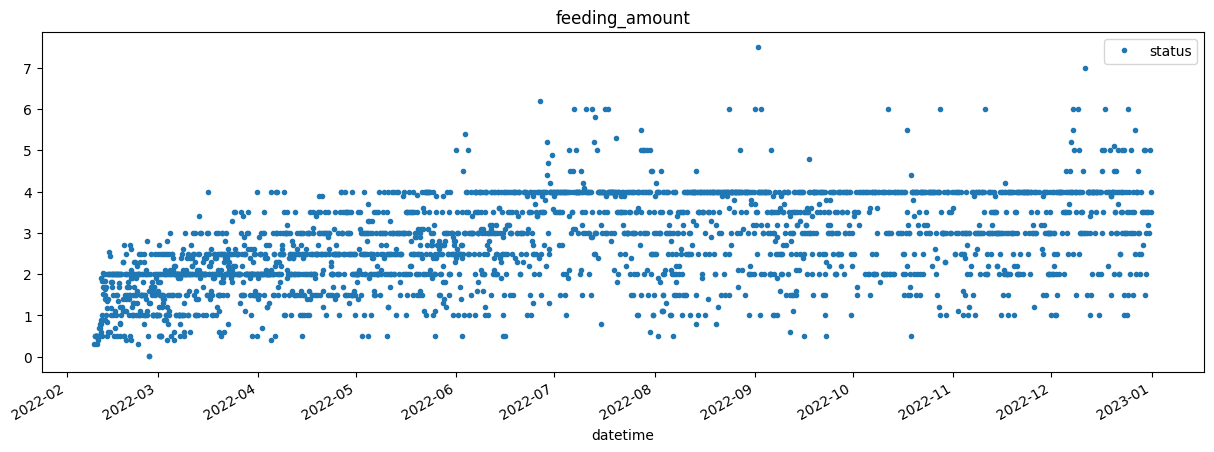

In [11]:
selected_columns.plot(style='.', figsize=(15,5), title='feeding_amount')

In [14]:
selected_columns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2643 entries, 2022-02-09 12:46:00 to 2022-12-31 21:13:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   status  2643 non-null   float64
dtypes: float64(1)
memory usage: 41.3 KB
